## STP correlation with Tornadoes
##### Dr. Victor Gensini (Spring 2018)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
import scipy.stats
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.stats.mstats import linregress
from scipy import stats
import shapefile
#import statsmodels.formula.api as sm
#import statsmodels.api as sm
#import seaborn as sns
#sns.set()

(365, 39, 277, 349)


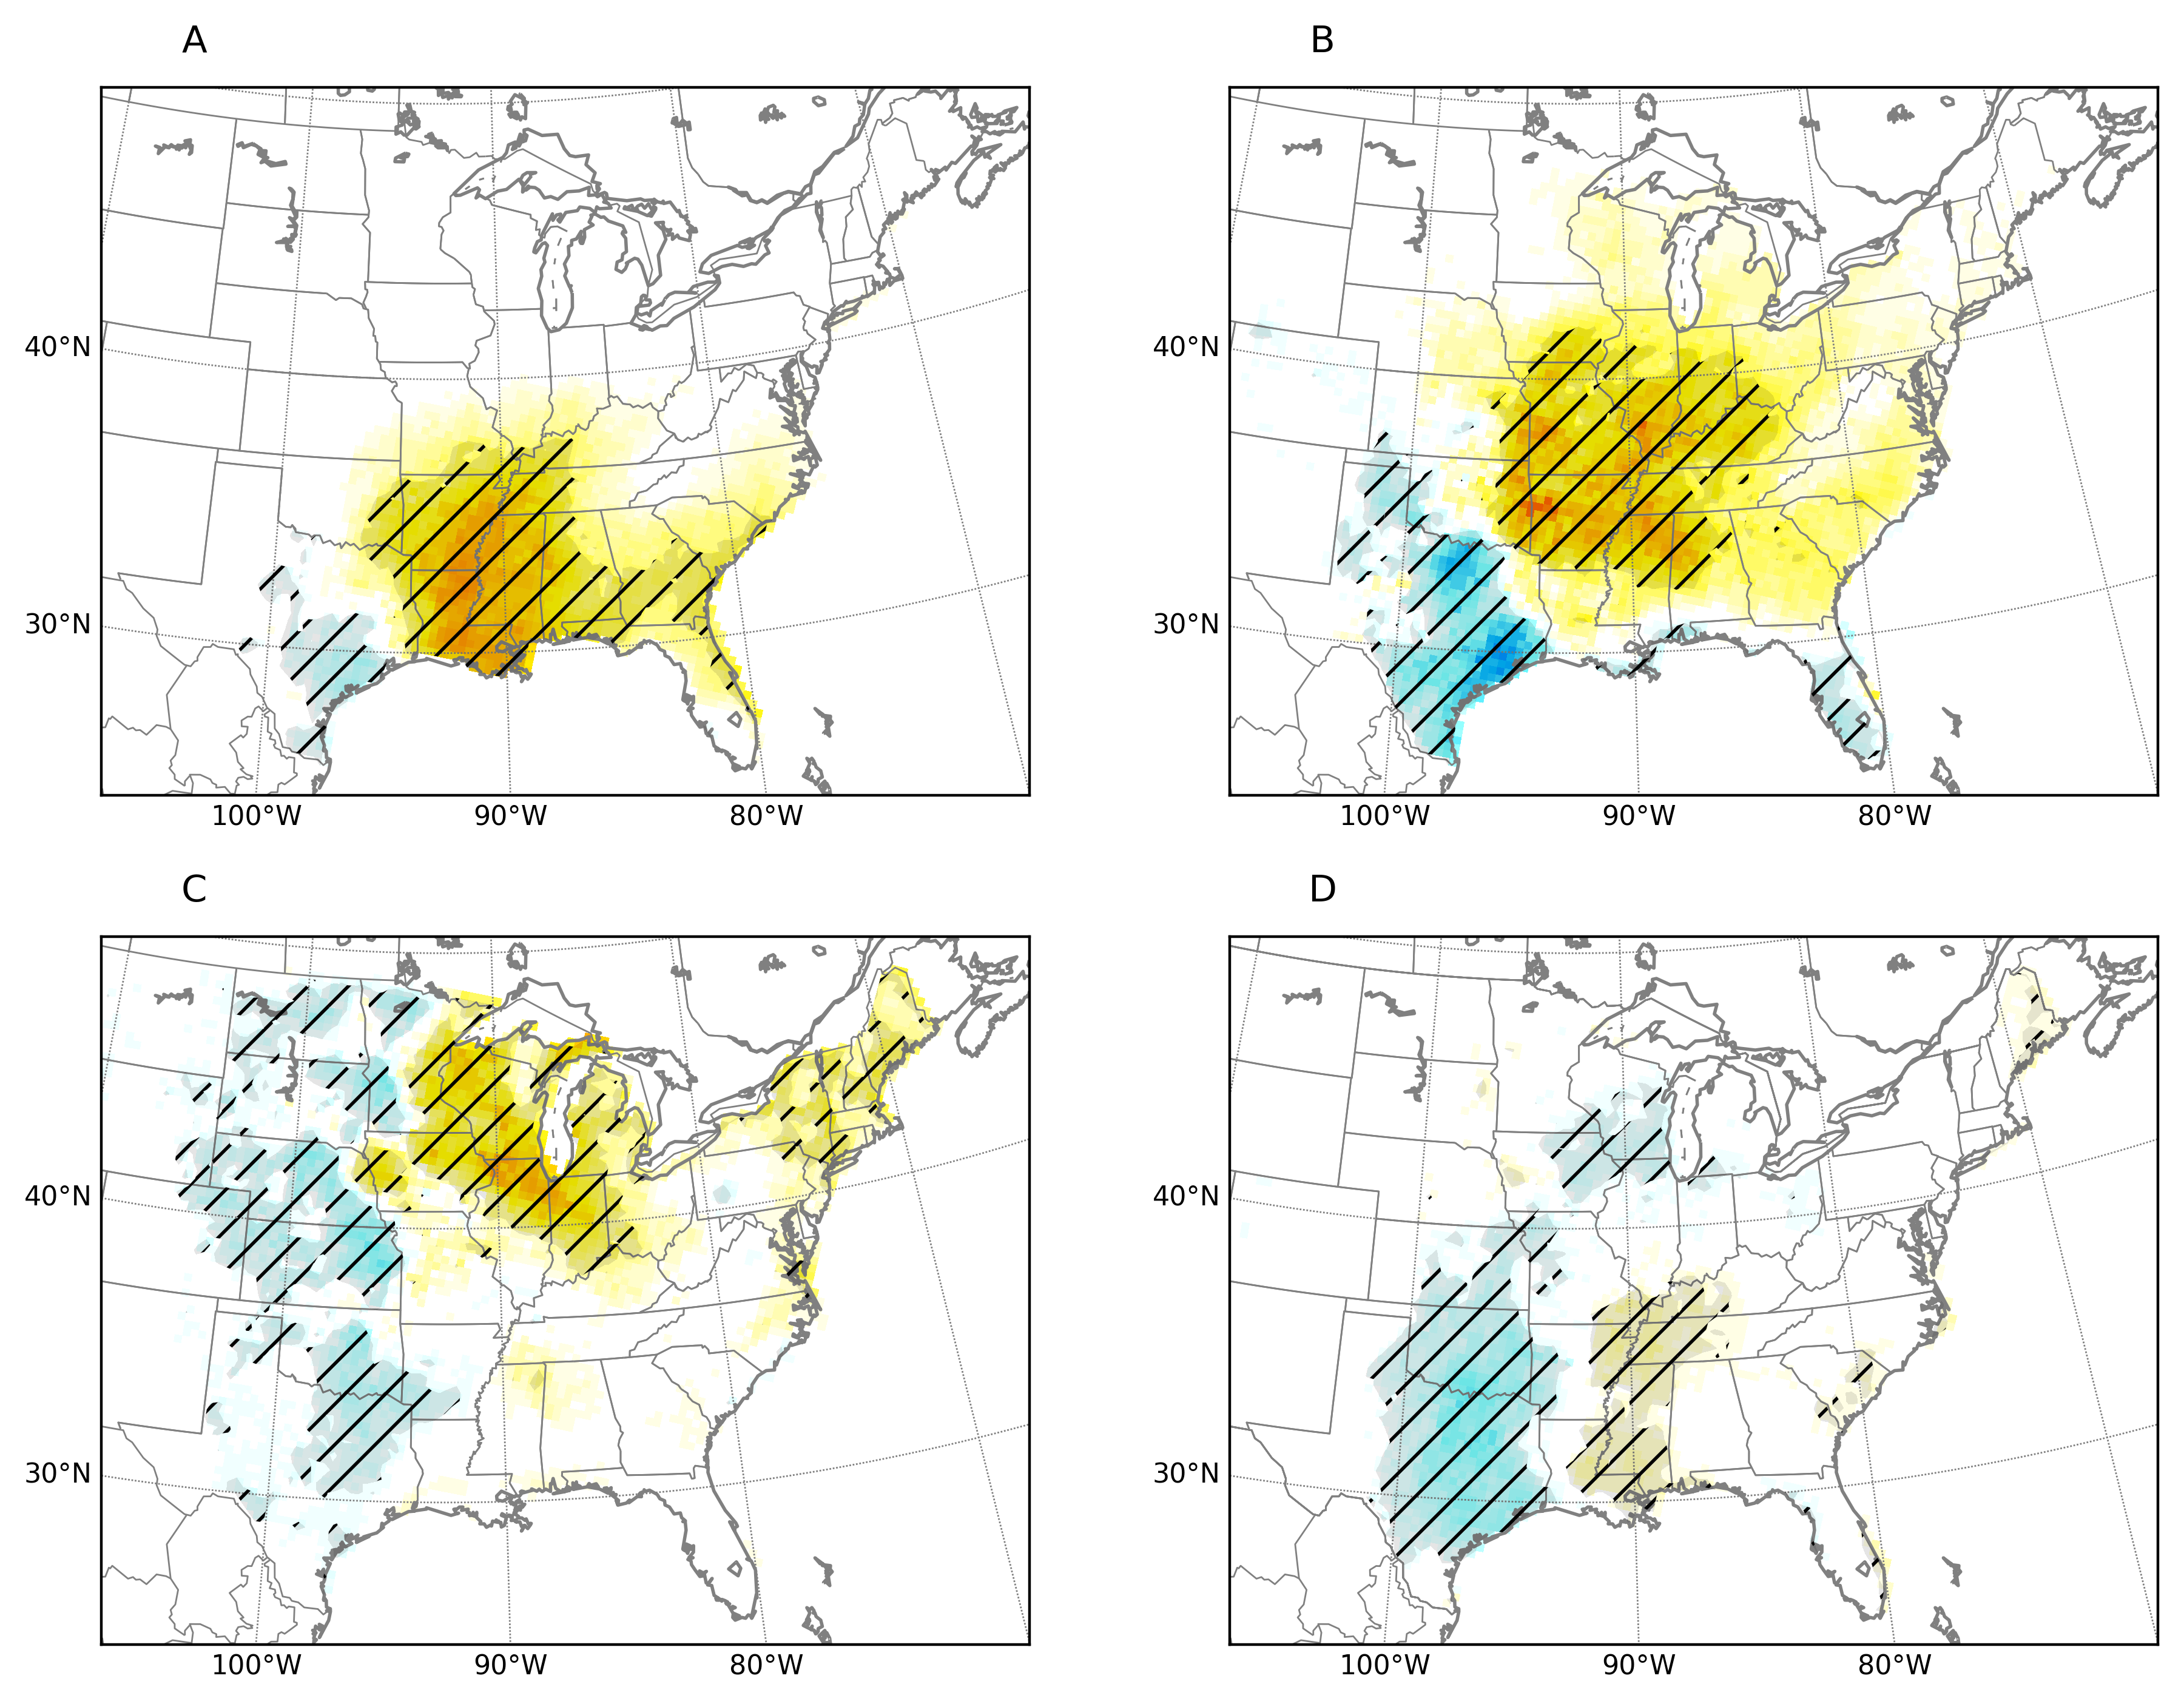

In [2]:
datadir = '/home/data/stp_narr/'
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()


fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(11,8.5),dpi=400)
for ax in axes.flat:
    m = Basemap(projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=24, urcrnrlat=47,llcrnrlon=-106,urcrnrlon=-61,resolution='l',area_thresh=1000,ax=ax)
    x,y = m(lons,lats)
    m.drawcoastlines(color='gray')
    m.drawstates(color='gray')
    m.drawcountries(color='gray')
    parallels = np.arange(0.,90,10.)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,color='grey',linewidth=0.5)
    meridians = np.arange(180.,360.,10.)
    m.drawmeridians(meridians,labels=[0,0,0,2],fontsize=8,color='grey',linewidth=0.5)


#read shapefile using pyshp (http://code.google.com/p/pyshp/)
sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/US_outline.shp')
sfrec = sf.shapeRecord()
points = sfrec.shape.points
#print points
latty_bin = lats.flatten()
lonny_bin = lons.flatten()
lonlat = []

for lt,ln in zip(latty_bin,lonny_bin):
    lonlat.append([ln,lt])
#use points_inside_polygon to 
#clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
path = Path(points)
clip = path.contains_points(lonlat)

#reshape array
clip = clip.reshape(lats.shape)

#read shapefile using pyshp (http://code.google.com/p/pyshp/)
sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/mask.shp')
sfrec = sf.shapeRecord()
points = sfrec.shape.points
#print points
latty_bin = lats.flatten()
lonny_bin = lons.flatten()
lonlat = []

for lt,ln in zip(latty_bin,lonny_bin):
    lonlat.append([ln,lt])
#use points_inside_polygon to 
#clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
path = Path(points)
clip1 = path.contains_points(lonlat)

#reshape array
clip1 = clip1.reshape(lats.shape)


stp_gt1_all=np.load(datadir+'narr_stp_diurnal_max_79_17.npy')
#stp_gt1_all=np.load(datadir+'stp_00z.npy')
print (stp_gt1_all.shape)
#JF 0:61
#MAM 60:153
#JJA 153:244
#SON 244:335
#DJF [0:61][335:366]
stp_gt1_all1 = np.concatenate([stp_gt1_all[0:61,:,:,:],stp_gt1_all[335:366,:,:,:]])
#stp_gt1_all = stp_gt1_all[0:61,:,:,:]
#stp_gt1_all_1 = stp_gt1_all[335:366,:,:,:]
#stp_gt1_all = np.append(stp_gt1_all,stp_gt1_all_1)
inter_var = np.sum(stp_gt1_all1,axis=0)
#sigma = 1
#inter_var = scipy.ndimage.filters.gaussian_filter(inter_var,sigma,order=0)
jul_vals =[]
doy = np.arange(0,365,1,dtype=np.int)
years = np.arange(0,38,1,dtype=np.int)
#plt.figure(figsize=(18,11))
#for yr in years:
#    stp_dy_val = inter_var[yr,:,:]
#    stp_dy_val_clip = np.ma.masked_where(clip==False,stp_dy_val)
#    jul_vals.append(stp_dy_val_clip.sum())


def theilsen(a,years):
    yr,y,x = a.shape
    slope = np.zeros((y,x))   
    intercept = np.zeros((y,x))   
    lo = np.zeros((y,x))
    up = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
    return slope

def kendalltau(a,years):
    yr,y,x = a.shape   
    tau = np.zeros((y,x))   
    pval = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
    #return (tau,pval)
    return pval

slope = theilsen(inter_var,np.arange(1979,2018,1))

#masked = maskoceans(lons,lats,slope)
masked = np.ma.masked_where(clip==False,slope)
#masked1 = maskoceans(lons,lats,pval)
#masked1 = np.ma.masked_where(clip1==False,pval)
m.drawcountries(color='gray')
x,y = m(lons,lats)
temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
cmap = matplotlib.colors.ListedColormap(temper_anom)
plot = axes.flat[0].pcolormesh(x,y,masked,zorder=1,vmin=-1, vmax=1,cmap=cmap)
#colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
#colbar.set_label('1979-2017 Theil-Sen Slope of Annual STP',fontsize='medium',weight='bold')
#levs = [-0.05,0.001]
#masked1 = np.ma.masked_greater(masked1, 0.05)
#m.pcolor(x, y, masked1, hatch='.', alpha=0.)
#m.contour(scipy.ndimage.zoom(x, 2),scipy.ndimage.zoom(y, 2),scipy.ndimage.zoom(masked1, 2),levs,colors='black')
levs = [1.3,1000000]
levs1 = [-100000,-.8]
pos = stats.zscore(masked,axis=None, ddof=39)
axes.flat[0].contourf(x,y,pos,levs,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)
axes.flat[0].contourf(x,y,pos,levs1,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)
#levs1 = [-900,-1.96]
#m.contourf(x,y,sigdiff,levs1,color=None,hatch=['/'])
#plt.tight_layout()
#plt.savefig('monthly_slopes.png',dpi=100)

#JF 0:61
#MAM 60:153
#JJA 153:244
#SON 244:335
#DJF [0:61][335:366]
stp_gt1_all1 = stp_gt1_all[60:153,:,:,:]
#stp_gt1_all = stp_gt1_all[0:61,:,:,:]
#stp_gt1_all_1 = stp_gt1_all[335:366,:,:,:]
#stp_gt1_all = np.append(stp_gt1_all,stp_gt1_all_1)
inter_var = np.sum(stp_gt1_all1,axis=0)
#sigma = 1
#inter_var = scipy.ndimage.filters.gaussian_filter(inter_var,sigma,order=0)
jul_vals =[]
doy = np.arange(0,365,1,dtype=np.int)
years = np.arange(0,38,1,dtype=np.int)
#plt.figure(figsize=(18,11))
#for yr in years:
#    stp_dy_val = inter_var[yr,:,:]
#    stp_dy_val_clip = np.ma.masked_where(clip==False,stp_dy_val)
#    jul_vals.append(stp_dy_val_clip.sum())


def theilsen(a,years):
    yr,y,x = a.shape
    slope = np.zeros((y,x))   
    intercept = np.zeros((y,x))   
    lo = np.zeros((y,x))
    up = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
    return slope

def kendalltau(a,years):
    yr,y,x = a.shape   
    tau = np.zeros((y,x))   
    pval = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
    #return (tau,pval)
    return pval

slope = theilsen(inter_var,np.arange(1979,2018,1))
#pval = kendalltau(inter_var,np.arange(1979,2018,1))

#masked = maskoceans(lons,lats,slope)
masked = np.ma.masked_where(clip==False,slope)
#masked1 = maskoceans(lons,lats,pval)
#masked1 = np.ma.masked_where(clip1==False,pval)
m.drawcountries(color='gray')
x,y = m(lons,lats)
temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
cmap = matplotlib.colors.ListedColormap(temper_anom)
plot = axes.flat[1].pcolormesh(x,y,masked,zorder=1,vmin=-1, vmax=1,cmap=cmap)
#colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
#colbar.set_label('1979-2017 Theil-Sen Slope of Annual STP',fontsize='medium',weight='bold')
#levs = [-0.05,0.001]
#masked1 = np.ma.masked_greater(masked1, 0.05)
#m.pcolor(x, y, masked1, hatch='.', alpha=0.)
#m.contour(scipy.ndimage.zoom(x, 2),scipy.ndimage.zoom(y, 2),scipy.ndimage.zoom(masked1, 2),levs,colors='black')
pos = stats.zscore(masked,axis=None, ddof=39)
axes.flat[1].contourf(x,y,pos,levs,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)
axes.flat[1].contourf(x,y,pos,levs1,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)

stp_gt1_all1 = stp_gt1_all[153:244,:,:,:]
#stp_gt1_all = stp_gt1_all[0:61,:,:,:]
#stp_gt1_all_1 = stp_gt1_all[335:366,:,:,:]
#stp_gt1_all = np.append(stp_gt1_all,stp_gt1_all_1)
inter_var = np.sum(stp_gt1_all1,axis=0)
#sigma = 1
#inter_var = scipy.ndimage.filters.gaussian_filter(inter_var,sigma,order=0)
jul_vals =[]
doy = np.arange(0,365,1,dtype=np.int)
years = np.arange(0,38,1,dtype=np.int)
#plt.figure(figsize=(18,11))
#for yr in years:
#    stp_dy_val = inter_var[yr,:,:]
#    stp_dy_val_clip = np.ma.masked_where(clip==False,stp_dy_val)
#    jul_vals.append(stp_dy_val_clip.sum())


def theilsen(a,years):
    yr,y,x = a.shape
    slope = np.zeros((y,x))   
    intercept = np.zeros((y,x))   
    lo = np.zeros((y,x))
    up = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
    return slope

def kendalltau(a,years):
    yr,y,x = a.shape   
    tau = np.zeros((y,x))   
    pval = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
    #return (tau,pval)
    return pval

slope = theilsen(inter_var,np.arange(1979,2018,1))
#pval = kendalltau(inter_var,np.arange(1979,2018,1))

#masked = maskoceans(lons,lats,slope)
masked = np.ma.masked_where(clip==False,slope)
#masked1 = maskoceans(lons,lats,pval)
#masked1 = np.ma.masked_where(clip1==False,pval)
m.drawcountries(color='gray')
x,y = m(lons,lats)
temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
cmap = matplotlib.colors.ListedColormap(temper_anom)
plot = axes.flat[2].pcolormesh(x,y,masked,zorder=1,vmin=-1, vmax=1,cmap=cmap)
#colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
#colbar.set_label('1979-2017 Theil-Sen Slope of Annual STP',fontsize='medium',weight='bold')
#levs = [-0.05,0.001]
#masked1 = np.ma.masked_greater(masked1, 0.05)
#m.pcolor(x, y, masked1, hatch='.', alpha=0.)
#m.contour(scipy.ndimage.zoom(x, 2),scipy.ndimage.zoom(y, 2),scipy.ndimage.zoom(masked1, 2),levs,colors='black')
pos = stats.zscore(masked,axis=None, ddof=39)
axes.flat[2].contourf(x,y,pos,levs,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)
axes.flat[2].contourf(x,y,pos,levs1,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)

stp_gt1_all1 = stp_gt1_all[244:335,:,:,:]
#stp_gt1_all = stp_gt1_all[0:61,:,:,:]
#stp_gt1_all_1 = stp_gt1_all[335:366,:,:,:]
#stp_gt1_all = np.append(stp_gt1_all,stp_gt1_all_1)
inter_var = np.sum(stp_gt1_all1,axis=0)
#sigma = 1
#inter_var = scipy.ndimage.filters.gaussian_filter(inter_var,sigma,order=0)
jul_vals =[]
doy = np.arange(0,365,1,dtype=np.int)
years = np.arange(0,38,1,dtype=np.int)
#plt.figure(figsize=(18,11))
#for yr in years:
#    stp_dy_val = inter_var[yr,:,:]
#    stp_dy_val_clip = np.ma.masked_where(clip==False,stp_dy_val)
#    jul_vals.append(stp_dy_val_clip.sum())


def theilsen(a,years):
    yr,y,x = a.shape
    slope = np.zeros((y,x))   
    intercept = np.zeros((y,x))   
    lo = np.zeros((y,x))
    up = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
    return slope

def kendalltau(a,years):
    yr,y,x = a.shape   
    tau = np.zeros((y,x))   
    pval = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
    #return (tau,pval)
    return pval

slope = theilsen(inter_var,np.arange(1979,2018,1))
#pval = kendalltau(inter_var,np.arange(1979,2018,1))

#masked = maskoceans(lons,lats,slope)
masked = np.ma.masked_where(clip==False,slope)
#masked1 = maskoceans(lons,lats,pval)
#masked1 = np.ma.masked_where(clip1==False,pval)
m.drawcountries(color='gray')
x,y = m(lons,lats)
temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
cmap = matplotlib.colors.ListedColormap(temper_anom)
plot = axes.flat[3].pcolormesh(x,y,masked,zorder=1,vmin=-1, vmax=1,cmap=cmap)
#colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
#colbar.set_label('1979-2017 Theil-Sen Slope of Annual STP',fontsize='medium',weight='bold')
#levs = [-0.05,0.001]
#masked1 = np.ma.masked_greater(masked1, 0.05)
#m.pcolor(x, y, masked1, hatch='.', alpha=0.)
#m.contour(scipy.ndimage.zoom(x, 2),scipy.ndimage.zoom(y, 2),scipy.ndimage.zoom(masked1, 2),levs,colors='black')
pos = stats.zscore(masked,axis=None, ddof=39)
axes.flat[3].contourf(x,y,pos,levs,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)
axes.flat[3].contourf(x,y,pos,levs1,cmap=None,colors='black',alpha=.1,hatches=['//'],zorder=5)
axes.flat[0].annotate('A',(.1,1.05), xycoords='axes fraction', ha='center', fontsize=11)
axes.flat[1].annotate('B',(.1,1.05), xycoords='axes fraction', ha='center', fontsize=11)
axes.flat[2].annotate('C',(.1,1.05), xycoords='axes fraction', ha='center', fontsize=11)
axes.flat[3].annotate('D',(.1,1.05), xycoords='axes fraction', ha='center', fontsize=11)
plt.savefig('FigureS1.png')